# pfs - probability of fault slip
## Worked Example 1 - Slip & dilation tendency
First, some necessary loading of libraries. In addition to the standard Python set for numerical work, we need pfs.py and sga.py. 
pfs.py has definitions of all the functions that make up pfs. pfs.py imports sga.py, which has a Python implementation of selected functions converted from the MATLAB originals in Allmendiger et al. (2012) Structural Geology Algorithms.   

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import linalg
import pfs

Initialise some variables...

In [53]:
nMC = 5000          #   number of Monte Carlo runs 
nBins = 20          #   number of bins in histograms  

To calculate slip and dilation tendency ($T_s$ and $T_d$, respectively), we need the stress magnitudes, the azimuth of sHmax (assuming an Andersonian stress state, with one principal stress vertical), and the strike and dip of the fault plane. 

First up, we define the stress tensor. In this worked example, we'll use $\sigma_{1,2,3}$ nomenclature, rather than $\sigma_V, \sigma_H, \sigma_h$. We specify the mean and std dev of each normal distribution. The pfs function setStressDist() builds a consistent set of normally distributed stresses (of size $n_{MC}$), where $\sigma_1 >= \sigma_2 >= \sigma_3$. From these distributions, we get the min, max, mean, std dev and range for later use.   

In [54]:
#   sigma1 - most compressive, in MPa 
muS1 = 75.
sdS1 = muS1 * .05 
#   sigma2 - intermediate, in MPa 
muS2 = 50.
sdS2 = muS2 * .05
#   sigma3 - least compressive, in MPa 
muS3 = 25.
sdS3 = muS3 * .05

stress = pfs.setStressDist(nMC, muS1, sdS1, muS2, sdS2, muS3, sdS3)
S1 = stress[:,0]
S2 = stress[:,1]
S3 = stress[:,2]

minS1 = S1.min()
maxS1 = S1.max()
meanS1 = S1.mean()
stdS1 = S1.std()
rangeS1 = maxS1 - minS1 

minS2 = S2.min()
maxS2 = S2.max()
meanS2 = S2.mean()
stdS2 = S2.std()
rangeS2 = maxS2 - minS2 

minS3 = S3.min()
maxS3 = S3.max()
meanS3 = S3.mean()
stdS3 = S3.std()
rangeS3 = maxS3 - minS3 

Next, we define the orientation or azimuth of sHmax, in degrees from North. We use a von Mises - or circular normal - distribution. And we get the circular mean and std dev for later use. $\kappa$ is the dispersion parameter for a von Mises distribution (higher = less dispersed). Note that we 'correct' any azimuths outside the range of 0-180. 

In [55]:
#   SHmax azimuth
#   von Mises circular normal distribution 
SHazMean = 60.
SHazKappa = 200. 
#   von Mises symmetrical about mean, in range -pi to +pi
SHaz = pfs.rad2deg(np.random.vonmises(pfs.deg2rad(SHazMean), SHazKappa, nMC))
minSHaz, maxSHaz, meanSHaz, medianSHaz = pfs.getCircStats(SHaz) 
rangeSHaz = maxSHaz - np.abs(minSHaz) 
SHazTrue = SHaz
SHaz[np.ix_(SHaz<0)] += 180.
SHaz[np.ix_(SHaz>180)] -= 180.

Next up, we define the fault orientation and uncertainty thereof. And enforce a "right hand rule" convention: with the palm of your right hand on the fault plane and fingers pointing down dip, your right thumb points in the direction of strike. Again, we collect the stats for later use.     

In [56]:
#   fault strike, degrees 
#   von Mises circular normal distribution 
muStrike = 60.
kappaStrike = 200. 

#   fault dip, degrees 
#   von Mises circular normal distribution 
muDip = 60.
kappaDip = 200. 

#   rationalise the fault plane distribution to conform to right-hand rule 
#   strike < 180, dip component to South (dip always <= 90) 
#   strike > 180, dip component to North (dip always <= 90) 
Strike, StrikeTrue, Dip = pfs.setFaultDist(nMC, muStrike, kappaStrike, muDip, kappaDip)

minStrike, maxStrike, meanStrike, medianStrike = pfs.getCircStats(StrikeTrue) 
rangeStrike = StrikeTrue.max() - StrikeTrue.min() 

minDip, maxDip, meanDip, medianDip = pfs.getCircStats(Dip) 
rangeDip = maxDip - minDip 

As a useful cross check before we start calculating, let's plot the six input variable distributions in histogram form...

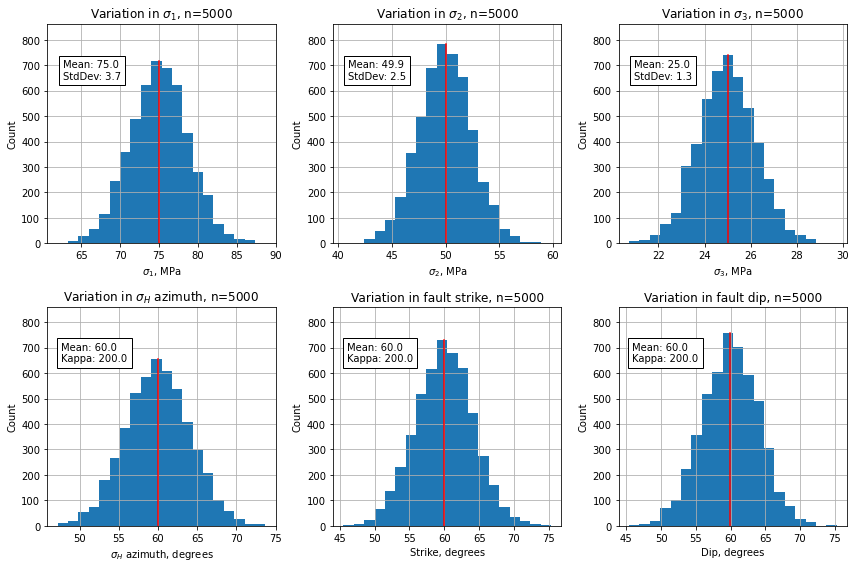

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))

nS1, bS1, pS1 = axs[0,0].hist(S1, nBins)
nS2, bS2, pS2 = axs[0,1].hist(S2, nBins)
nS3, bS3, pS3 = axs[0,2].hist(S3, nBins)
nSHaz, bSHaz, pSHaz = axs[1,0].hist(SHaz, nBins)
nStrike, bStrike, pStrike = axs[1,1].hist(Strike, nBins)
nDip, bDip, pDip = axs[1,2].hist(Dip, nBins)

nMax = np.max([nS3.max(), nS2.max(), nS1.max(), nSHaz.max(), nStrike.max(), nDip.max()])*1.1 

axs[0,0].plot([muS1, muS1], [0, np.max(nS1)], '-r')
axs[0,0].text(S1.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS1, stdS1)), 
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,0].set_ylim(0., nMax)
axs[0,0].set_xlabel(r'$\sigma_1$, MPa')
axs[0,0].set_ylabel('Count')
#axs[0,0].set_xlim(0, maxS1*1.1)
axs[0,0].grid(True)
axs[0,0].set_title(r'Variation in $\sigma_1$, n=%i' % nMC)

axs[0,1].plot([muS2, muS2], [0, np.max(nS2)], '-r')
axs[0,1].text(S2.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS2, stdS2)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,1].set_ylim(0., nMax)
axs[0,1].set_xlabel(r'$\sigma_2$, MPa')
axs[0,1].set_ylabel('Count')
#axs[0,1].set_xlim(0, maxS1*1.1)
axs[0,1].grid(True)
axs[0,1].set_title(r'Variation in $\sigma_2$, n=%i' % nMC)

axs[0,2].plot([muS3, muS3], [0, np.max(nS3)], '-r')
axs[0,2].text(S3.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS3, stdS3)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[0,2].set_ylim(0., nMax)
axs[0,2].set_xlabel(r'$\sigma_3$, MPa')
axs[0,2].set_ylabel('Count')
#axs[0,2].set_xlim(0., maxS1*1.1)
axs[0,2].grid(True)
axs[0,2].set_title(r'Variation in $\sigma_3$, n=%i' % nMC)

axs[1,0].plot([meanSHaz, meanSHaz], [0, np.max(nSHaz)], '-r')
axs[1,0].text(minSHaz*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (meanSHaz, SHazKappa)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,0].set_ylim(0., nMax)
axs[1,0].set_xlabel(r'$\sigma_H$ azimuth, degrees')
axs[1,0].set_ylabel('Count')
#axs[1,0].set_xlim(0., 180.)
axs[1,0].grid(True)
axs[1,0].set_title(r'Variation in $\sigma_H$ azimuth, n=%i' % nMC)

axs[1,1].plot([meanStrike, meanStrike], [0, np.max(nStrike)], '-r')
axs[1,1].text(minStrike*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muStrike, kappaStrike)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,1].set_ylim(0., nMax)
axs[1,1].set_xlabel('Strike, degrees')
axs[1,1].set_ylabel('Count')
#axs[1,1].set_xlim(0., 360.)
axs[1,1].grid(True)
axs[1,1].set_title('Variation in fault strike, n=%i' % nMC)

axs[1,2].plot([meanDip, meanDip], [0, np.max(nDip)], '-r')
axs[1,2].text(minDip*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muDip, kappaDip)),
                           bbox=dict(facecolor='white', edgecolor='black'))
axs[1,2].set_ylim(0., nMax)
axs[1,2].set_xlabel('Dip, degrees')
axs[1,2].set_ylabel('Count')
#axs[1,2].set_xlim(0., 90.)
axs[1,2].grid(True)
axs[1,2].set_title('Variation in fault dip, n=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_input_hist.png', dpi=300)

Too easy. 

Also, we can plot a Mohr diagram to visualise the key issue: given the known variations in stress (as specified through the std devs used in their normal distributions), what is the probability that any of the stress states will exceed the Mohr-Coulomb failure criterion? For a simple example, we can just assume cohesion $C_0$=0, and the coefficient of friction $\mu$=0.6...

In [ ]:
#   Mohr plot showing variations in stresses 
pfs.plotMohr(S1, S2, S3, 0.6, 0.0)

The mean value of the max. differential stress ($\sigma_D$ = $\sigma_1$-$\sigma_3$) is shown in red, and the variations shown in grey. 

Q: How many of those grey stress states cut the M-C sliding failure line? 

We'll use a Response Surface approach, combined with a Monte Carlo simulation to produce a statistically viable set of predictions from which we can infer the probability of slip. 

## Linear response surfaces for slip & dilation tendencies 
We will solve the linear system of equations for $$y = \beta X_l$$ for $\beta$, the vector of coefficients of the Response Surface. 

The number of variables, $q$, is 6. $y$ is a vector of "responses" (in our case, either $T_s$ or $T_d$), and $X_l$ is a matrix (N x q+1) of dummy or coded variables, one for each of the inputs defined above. 

To define the response surface, we only use the min, max and mean of each input variable, in a so-called $3^q$ sample design. As such, the values in $X_l$ are set to -1 (min), 0 (mean) and +1 (max). Each row in $X_l$ is for a different permutation of the 6 input variables values, and each column is for a different variable. 

In [58]:
q = 6                    #   6 variables, linear terms only 
nTsTd = pow(3,q)         #   3 coordinates for each variable 
    
#   solve y = Beta.Xl for Beta as the coefficients in the regression
#   Xl is the 'design matrix' of dummy variables; one per variable 
#   values of -1 = min, 0 = mean, +1 = max
Xl = np.zeros([nTsTd,q+1])
iRow = 0 
for iA in range(-1,+2):
    for iB in range(-1,+2):
        for iC in range(-1,+2):
            for iD in range(-1,+2):
                for iE in range(-1,+2):
                      for iF in range(-1,+2):
                          Xl[iRow, :] = [1, iA, iB, iC, iD, iE, iF]
                          iRow += 1

Now we define the $y$ vectors of response values, one each for slip and dilation tendency. We use scaled values of input variables - using the -1, 0 and +1 from the $X_l$ matrix - to calculate scaled values of $y$ ($T_s$ and $T_d$) at each combination in $X_l$. 

In [60]:
yS1 = np.zeros([nTsTd,])
yS2 = np.zeros([nTsTd,])
yS3 = np.zeros([nTsTd,])
ysigmaN = np.zeros([nTsTd,])
ytau = np.zeros([nTsTd,])
yTs = np.zeros([nTsTd,])
yTd = np.zeros([nTsTd,])

for i in range(0,nTsTd):
    yS1 = Xl[i,1] * rangeS1 / 2. + meanS1 
    yS2 = Xl[i,2] * rangeS2 / 2. + meanS2 
    yS3 = Xl[i,3] * rangeS3 / 2. + meanS3 
    ySHaz = Xl[i,4] * rangeSHaz / 2. + meanSHaz 
    if ySHaz < 0.:
        ySHaz += 180.
    yStrike = Xl[i,5] * rangeStrike / 2. + meanStrike 
    if yStrike < 0.:
        yStrike += 360.
    yDip = Xl[i,6] * rangeDip / 2. + meanDip 
    
    ysigmaN[i], ytau[i] = pfs.calcAndersonianStressOnPlane(yS1, yS2, yS3, ySHaz, yStrike, yDip) 
    yTd[i] = (yS1 - ysigmaN[i])/(yS1 - yS3)
    
yTs = ytau / ysigmaN 

Now we solve for $\beta$ using standard least squares (thanks SciPy!)

In [61]:
#   solve for beta using least squares 
BetaTs, res, rank, s = linalg.lstsq(Xl, yTs)
BetaTd, res, rank, s = linalg.lstsq(Xl, yTd) 
    
print('Linear fit beta coefficients, for Ts:')
print(BetaTs.T)
print('Linear fit beta coefficients, for Td:')
print(BetaTd.T)

Linear fit beta coefficients, for Ts:
[ 4.98974074e-01  8.31634673e-02  4.34855388e-03 -8.89221301e-02
  1.44534307e-05 -1.55206684e-05 -9.39128929e-03]
Linear fit beta coefficients, for Td:
[ 6.98742801e-01  7.88529931e-03 -1.12803857e-02  2.36661208e-03
  2.84031948e-05 -3.22783378e-05  2.07436570e-01]


We can do all sorts with the results from linalg.lstsq(), including analysis of variance, t-statistics, residuals etc etc. First, let's just check the adjusted $R^2$ values for the linear response surfaces for $T_s$ and $T_d$

In [62]:
#   analyse variance, residuals etc 
RsqTs, RsqATs, FTs, MSRTs, MSETs = pfs.calcANOVAresid(yTs, Xl, BetaTs)
RsqTd, RsqATd, FTd, MSRTd, MSETd = pfs.calcANOVAresid(yTd, Xl, BetaTd)
sRsqTs = r'Adjusted $R^2$ for $T_s$ fit: {:.3f}'
sRsqTd = r'Adjusted $R^2$ for $T_d$ fit: {:.3f}'
#print(sRsqTs.format(RsqATs))
print(r'Adjusted $R^2$ for $T_s$ fit: %.3f' % RsqATs)
print(sRsqTd.format(RsqATd))

Adjusted $R^2$ for $T_s$ fit: 0.788
Adjusted $R^2$ for $T_d$ fit: 0.952


To plot the residuals on a normal probability plot, we need to calculate the $y$ values using the newly acquired $\beta$ coefficients, and then calculate the difference between these $y$ values and the ones used above  

In [ ]:
#   get errors (residuals) for linear/Ts
fitTs = np.zeros([nTsTd,])
fitTd = np.zeros([nTsTd,])

for i in range(0, nTsTd): 
    
    fitTs[i] = (BetaTs[0] + 
                BetaTs[1] * Xl[i, 1] +  
                BetaTs[2] * Xl[i, 2] +  
                BetaTs[3] * Xl[i, 3] +  
                BetaTs[4] * Xl[i, 4] +  
                BetaTs[5] * Xl[i, 5] +  
                BetaTs[6] * Xl[i, 6]) 
    
    fitTd[i] = (BetaTd[0] + 
                BetaTd[1] * Xl[i, 1] +  
                BetaTd[2] * Xl[i, 2] +  
                BetaTd[3] * Xl[i, 3] +  
                BetaTd[4] * Xl[i, 4] +  
                BetaTd[5] * Xl[i, 5] +  
                BetaTd[6] * Xl[i, 6]) 

eTs = yTs - fitTs
eTd = yTd - fitTd
pfs.plotResiduals(eTs, r'$T_s$ linear', sRsqTs.format(RsqATs))
pfs.plotResiduals(eTd, r'$T_d$ linear', sRsqTd.format(RsqATd)) 

Boom. Job: done. 

Let's repeat the trick for a quadratic - 2nd order - response surface, for both slip & dilation tendency. For this, we need to change the size and content of the $X$ matrix, to include terms for squares and cross-products. 

In [ ]:
q2 = 0.5 * q * (q + 1) + q  #   total terms incl. squares and products 
Xq = np.zeros([int(nTsTd), int(q2)+1])

for iQ in range(0,nTsTd):
    
    #   linear terms 
    Xq[iQ,1] = Xl[iQ,1]
    Xq[iQ,2] = Xl[iQ,2]
    Xq[iQ,3] = Xl[iQ,3]
    Xq[iQ,4] = Xl[iQ,4]
    Xq[iQ,5] = Xl[iQ,5]
    Xq[iQ,6] = Xl[iQ,6]
    
    #   cross products 
    Xq[iQ,7] = Xl[iQ,1]*Xl[iQ,2]
    Xq[iQ,8] = Xl[iQ,1]*Xl[iQ,3]
    Xq[iQ,9] = Xl[iQ,1]*Xl[iQ,4]
    Xq[iQ,10] = Xl[iQ,1]*Xl[iQ,5]
    Xq[iQ,11] = Xl[iQ,1]*Xl[iQ,6]
    Xq[iQ,12] = Xl[iQ,2]*Xl[iQ,3]
    Xq[iQ,13] = Xl[iQ,2]*Xl[iQ,4]
    Xq[iQ,14] = Xl[iQ,2]*Xl[iQ,5]
    Xq[iQ,15] = Xl[iQ,2]*Xl[iQ,6]
    Xq[iQ,16] = Xl[iQ,3]*Xl[iQ,4]
    Xq[iQ,17] = Xl[iQ,3]*Xl[iQ,5]
    Xq[iQ,18] = Xl[iQ,3]*Xl[iQ,6]
    Xq[iQ,19] = Xl[iQ,4]*Xl[iQ,5]
    Xq[iQ,20] = Xl[iQ,4]*Xl[iQ,6]
    Xq[iQ,21] = Xl[iQ,5]*Xl[iQ,6]
    
    #   squares 
    Xq[iQ,22] = Xl[iQ,1]*Xl[iQ,1]
    Xq[iQ,23] = Xl[iQ,2]*Xl[iQ,2]
    Xq[iQ,24] = Xl[iQ,3]*Xl[iQ,3]
    Xq[iQ,25] = Xl[iQ,4]*Xl[iQ,4]
    Xq[iQ,26] = Xl[iQ,5]*Xl[iQ,5]
    Xq[iQ,27] = Xl[iQ,6]*Xl[iQ,6]

Xq[:,0] = 1 
Xq2 = np.dot(Xq.T, Xq)  

And the $y$ values need adjusting too...

In [ ]:
#   get y values for Ts & Td 
yTsq = np.zeros([int(q2)+1,])
yTdq = np.zeros([int(q2)+1,])

for i in range(0, int(q2)+1):
    for j in range(0, nTsTd):
         yTsq[i] = yTsq[i] + Xq[j,i] * yTs[j] 
         yTdq[i] = yTdq[i] + Xq[j,i] * yTd[j] 

yTsq[0] = sum(yTs)
yTdq[0] = sum(yTd)

And now just least squares using the new $X$ and the new $y$ to get quadratic $\beta$...

In [ ]:
#   solve for beta using least squares 
BetaTs, res, rank, s = linalg.lstsq(Xq2, yTsq)
BetaTd, res, rank, s = linalg.lstsq(Xq2, yTdq) 
    
print('Quadratic fit beta coefficients, for Ts:')
print(BetaTs.T[0:7])
print('Quadratic fit beta coefficients, for Td:')
print(BetaTd.T[0:7])

Terms 1-6 (NB: but not the zeroth term) in the quadratic $\beta$ coefficients should be identical (or, as near as, numerically) to those calculated by the linear response surface; the 'added value' of the quadratic response surface comes from the better fit provided by the extra square and cross-product terms.  

For consistency and completeness, let's have the stats and the residuals for the quadratic response surfaces: 

In [ ]:
#   analyse variance, residuals etc 
RsqTs, RsqATs, FTs, MSRTs, MSETs = pfs.calcANOVAresid(yTs, Xq, BetaTs)
RsqTd, RsqATd, FTd, MSRTd, MSETd = pfs.calcANOVAresid(yTd, Xq, BetaTd)
sRsqTs = r'Adjusted $R^2$ for $T_s$ fit: {:.3f}'
sRsqTd = r'Adjusted $R^2$ for $T_d$ fit: {:.3f}'
print(sRsqTs.format(RsqATs))
print(sRsqTd.format(RsqATd))
    
#   get errors (residuals) for linear/Ts
fitTsq = np.zeros([nTsTd,])
fitTdq = np.zeros([nTsTd,])

for i in range(0, nTsTd): 
    
    fitTsq[i] = (BetaTs[0] + 
                 BetaTs[1] * Xq[i, 1] +  
                 BetaTs[2] * Xq[i, 2] +  
                 BetaTs[3] * Xq[i, 3] +  
                 BetaTs[4] * Xq[i, 4] +  
                 BetaTs[5] * Xq[i, 5] +
                 BetaTs[6] * Xq[i, 6] +
                 BetaTs[7] * Xq[i, 7] +
                 BetaTs[8] * Xq[i, 8] +
                 BetaTs[9] * Xq[i, 9] +
                 BetaTs[10] * Xq[i, 10] +
                 BetaTs[11] * Xq[i, 11] +
                 BetaTs[12] * Xq[i, 12] +
                 BetaTs[13] * Xq[i, 13] +
                 BetaTs[14] * Xq[i, 14] +
                 BetaTs[15] * Xq[i, 15] +
                 BetaTs[16] * Xq[i, 16] +
                 BetaTs[17] * Xq[i, 17] +
                 BetaTs[18] * Xq[i, 18] +
                 BetaTs[19] * Xq[i, 19] +
                 BetaTs[20] * Xq[i, 20] +
                 BetaTs[21] * Xq[i, 21] +
                 BetaTs[22] * Xq[i, 22] +
                 BetaTs[23] * Xq[i, 23] +
                 BetaTs[24] * Xq[i, 24] +
                 BetaTs[25] * Xq[i, 25] +
                 BetaTs[26] * Xq[i, 26] +
                 BetaTs[27] * Xq[i, 27]) 
    
    fitTdq[i] = (BetaTd[0] + 
                 BetaTd[1] * Xq[i, 1] +  
                 BetaTd[2] * Xq[i, 2] +  
                 BetaTd[3] * Xq[i, 3] +  
                 BetaTd[4] * Xq[i, 4] +  
                 BetaTd[5] * Xq[i, 5] + 
                 BetaTd[6] * Xq[i, 6] + 
                 BetaTd[7] * Xq[i, 7] + 
                 BetaTd[8] * Xq[i, 8] + 
                 BetaTd[9] * Xq[i, 9] + 
                 BetaTd[10] * Xq[i, 10] + 
                 BetaTd[11] * Xq[i, 11] + 
                 BetaTd[12] * Xq[i, 12] + 
                 BetaTd[13] * Xq[i, 13] + 
                 BetaTd[14] * Xq[i, 14] + 
                 BetaTd[15] * Xq[i, 15] + 
                 BetaTd[16] * Xq[i, 16] + 
                 BetaTd[17] * Xq[i, 17] + 
                 BetaTd[18] * Xq[i, 18] + 
                 BetaTd[19] * Xq[i, 19] + 
                 BetaTd[20] * Xq[i, 20] + 
                 BetaTd[21] * Xq[i, 21] + 
                 BetaTd[22] * Xq[i, 22] + 
                 BetaTd[23] * Xq[i, 23] + 
                 BetaTd[24] * Xq[i, 24] + 
                 BetaTd[25] * Xq[i, 25] + 
                 BetaTd[26] * Xq[i, 26] + 
                 BetaTd[27] * Xq[i, 27]) 
    
eTsq = yTs - fitTsq
eTdq = yTd - fitTdq
pfs.plotResiduals(eTsq, r'$T_s$ quadratic', sRsqTs.format(RsqATs))
pfs.plotResiduals(eTdq, r'$T_d$ quadratic', sRsqTd.format(RsqATd))

Tickety-boo. Both of those quadratic response surfaces are 'better' (higher adjusted $R^2$ values) than their linear equivalents. 

Now we have defined acceptable response surfaces linking $T_s$ and $T_d$ to the min, mean and max of the input variable distributions, we can now run Monte Carlo simulations over the whole distribution of each variable (e.g., for $n_{MC}$ = 5000, or whatever), and get a statistically viable ensemble of predictions to help us with the probability. 

Remember that the $\beta$ coefficients defining the response surfaces were for coded or scaled variables; so we need to scale back to 'real' values for use in the Monte Carlo simulation (Monte Carlo is Italian for "really big loop"). 

Check it out:

In [ ]:
#   Monte Carlo simulation using quadratic response surface 
mcTsq = np.zeros([nMC,])
mcTdq = np.zeros([nMC,])
xS1 = (S1 - meanS1) / (rangeS1 / 2.)  
xS2 = (S2 - meanS2) / (rangeS2 / 2.)  
xS3 = (S3 - meanS3) / (rangeS3 / 2.)  
xSHaz = (SHazTrue - meanSHaz) / (rangeSHaz / 2.)  
xStrike = (StrikeTrue - meanStrike) / (rangeStrike / 2.)  
xDip = (Dip - meanDip) / (rangeDip / 2.)  

for i in range(0, nMC):
    
    mcTsq[i] = (BetaTs[0] + 
                BetaTs[1] * xS1[i] +
                BetaTs[2] * xS2[i] +
                BetaTs[3] * xS3[i] +
                BetaTs[4] * xSHaz[i] +
                BetaTs[5] * xStrike[i] +
                BetaTs[6] * xDip[i] +
                BetaTs[7] * xS1[i] * xS2[i] + 
                BetaTs[8] * xS1[i] * xS3[i] + 
                BetaTs[9] * xS1[i] * xSHaz[i] + 
                BetaTs[10] * xS1[i] * xStrike[i] + 
                BetaTs[11] * xS1[i] * xDip[i] + 
                BetaTs[12] * xS2[i] * xS3[i] + 
                BetaTs[13] * xS2[i] * xSHaz[i] + 
                BetaTs[14] * xS2[i] * xStrike[i] + 
                BetaTs[15] * xS2[i] * xDip[i] + 
                BetaTs[16] * xS3[i] * xSHaz[i] + 
                BetaTs[17] * xS3[i] * xStrike[i] + 
                BetaTs[18] * xS3[i] * xDip[i] + 
                BetaTs[19] * xSHaz[i] * xStrike[i] + 
                BetaTs[20] * xSHaz[i] * xDip[i] + 
                BetaTs[21] * xStrike[i] * xDip[i] + 
                BetaTs[22] * xS1[i] * xS1[i] + 
                BetaTs[23] * xS2[i] * xS2[i] + 
                BetaTs[24] * xS3[i] * xS3[i] + 
                BetaTs[25] * xSHaz[i] * xSHaz[i] + 
                BetaTs[26] * xStrike[i] * xStrike[i] + 
                BetaTs[27] * xDip[i] * xDip[i])
    
    mcTdq[i] = (BetaTd[0] + 
                BetaTd[1] * xS1[i] +
                BetaTd[2] * xS2[i] +
                BetaTd[3] * xS3[i] +
                BetaTd[4] * xSHaz[i] +
                BetaTd[5] * xStrike[i] +
                BetaTd[6] * xDip[i] +
                BetaTd[7] * xS1[i] * xS2[i] + 
                BetaTd[8] * xS1[i] * xS3[i] + 
                BetaTd[9] * xS1[i] * xSHaz[i] + 
                BetaTd[10] * xS1[i] * xStrike[i] + 
                BetaTd[11] * xS1[i] * xDip[i] + 
                BetaTd[12] * xS2[i] * xS3[i] + 
                BetaTd[13] * xS2[i] * xSHaz[i] + 
                BetaTd[14] * xS2[i] * xStrike[i] + 
                BetaTd[15] * xS2[i] * xDip[i] + 
                BetaTd[16] * xS3[i] * xSHaz[i] + 
                BetaTd[17] * xS3[i] * xStrike[i] + 
                BetaTd[18] * xS3[i] * xDip[i] + 
                BetaTd[19] * xSHaz[i] * xStrike[i] + 
                BetaTd[20] * xSHaz[i] * xDip[i] + 
                BetaTd[21] * xStrike[i] * xDip[i] + 
                BetaTd[22] * xS1[i] * xS1[i] + 
                BetaTd[23] * xS2[i] * xS2[i] + 
                BetaTd[24] * xS3[i] * xS3[i] + 
                BetaTd[25] * xSHaz[i] * xSHaz[i] + 
                BetaTd[26] * xStrike[i] * xStrike[i] + 
                BetaTd[27] * xDip[i] * xDip[i])

Now we've done the hard work, we can visualise the results. A histogram is nearly always a good place to start...

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

n, b, p = ax.hist(mcTsq.T, nBins)

sortedb = b[n.argsort()]
incb = b[1] - b[0]
mcTsqMode = sortedb[-1] + incb/2. 

ax.plot([mcTsqMode, mcTsqMode], [0, np.max(n)*1.1], 
                '--r', label='Mode = %1.2f' % mcTsqMode)
ax.grid(True)
ax.set_xlim(0., 1.)
ax.set_xlabel('Slip tendency')
ax.set_ylabel('Count')
ax.legend()
ax.set_title(r'Monte Carlo simulation for $T_s$, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_MC_hist_Ts.png', dpi=300)

fig, ax = plt.subplots(figsize=(4,4))

n, b, p = ax.hist(mcTdq.T, nBins)

sortedb = b[n.argsort()]
incb = b[1] - b[0]
mcTdqMode = sortedb[-1] + incb/2. 

ax.plot([mcTdqMode, mcTdqMode], [0, np.max(n)*1.1], 
                '--r', label='Mode = %1.2f' % mcTdqMode)
ax.grid(True)
ax.set_xlim(0., 1.)
ax.set_xlabel('Dilation tendency')
ax.set_ylabel('Count')
ax.legend()
ax.set_title(r'Monte Carlo simulation for $T_d$, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_MC_hist_Td.png', dpi=300)

Neat. A cumulative distribution function (CDF) of results is also useful: 

In [ ]:
#   CDF plots 
fig, ax = plt.subplots(figsize=(4,4))

sortTs = np.sort(mcTsq)
cumTs = (np.cumsum(sortTs) / np.sum(sortTs)) * 100.

ax.plot(sortTs, cumTs, '-r', linewidth=2, label='Ts CDF')
ax.grid(True)
ax.set_xlim(0., 1.)
ax.set_ylim(0., 100.) 
ax.set_xlabel('Slip tendency')
ax.set_ylabel('Percentage, %')
ax.set_title(r'Monte Carlo simulation for $T_s$, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_MC_CDF_Ts.png', dpi=300)

fig, ax = plt.subplots(figsize=(4,4))

sortTd = np.sort(mcTdq)
cumTd = (np.cumsum(sortTd) / np.sum(sortTd)) * 100.    

ax.plot(sortTd, cumTd, '-C0', linewidth=2, label='Td CDF')
ax.grid(True)
ax.set_xlim(0., 1.)
ax.set_ylim(0., 100.) 
ax.set_xlabel('Dilation tendency')
ax.set_ylabel('Percentage, %')
ax.set_title(r'Monte Carlo simulation for $T_d$, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_MC_CDF_Td.png', dpi=300)

Finally, we can re-visit our input variable distributions plotted as histograms, and overlay the response surface calculated for that variable holding all the other variables at their meaan values. These can be considered as 'sections' through the multivariate response surface (visualising a 6-dimensional surface is non-trivial!). 

Separate plots for $T_s$ and $T_d$:

In [ ]:
#   plot input distribution histograms with response surfaces 
#   overlain calculated for mean values of all other params 
s1Tsq = np.zeros([nMC,])
s1Tdq = np.zeros([nMC,])
s2Tsq = np.zeros([nMC,])
s2Tdq = np.zeros([nMC,])
s3Tsq = np.zeros([nMC,])
s3Tdq = np.zeros([nMC,])
sHazTsq = np.zeros([nMC,])
sHazTdq = np.zeros([nMC,])
strikeTsq = np.zeros([nMC,])
strikeTdq = np.zeros([nMC,])
dipTsq = np.zeros([nMC,])
dipTdq = np.zeros([nMC,])

for i in range(0, nMC):
    
    s1Tsq[i] = (BetaTs[0] + 
                BetaTs[1] * xS1[i] +
                BetaTs[22] * xS1[i] * xS1[i])

    s1Tdq[i] = (BetaTd[0] + 
                BetaTd[1] * xS1[i] +
                BetaTd[22] * xS1[i] * xS1[i])
    
    s2Tsq[i] = (BetaTs[0] + 
                BetaTs[2] * xS2[i] +
                BetaTs[23] * xS2[i] * xS2[i])

    s2Tdq[i] = (BetaTd[0] + 
                BetaTd[2] * xS2[i] +
                BetaTd[23] * xS2[i] * xS2[i])
        
    s3Tsq[i] = (BetaTs[0] + 
                BetaTs[3] * xS3[i] +
                BetaTs[24] * xS3[i] * xS3[i])

    s3Tdq[i] = (BetaTd[0] + 
                BetaTd[3] * xS3[i] +
                BetaTd[24] * xS3[i] * xS3[i])

    sHazTsq[i] = (BetaTs[0] + 
                  BetaTs[4] * xSHaz[i] +
                  BetaTs[25] * xSHaz[i] * xSHaz[i])

    sHazTdq[i] = (BetaTd[0] + 
                  BetaTd[4] * xSHaz[i] +
                  BetaTd[25] * xSHaz[i] * xSHaz[i])
        
    strikeTsq[i] = (BetaTs[0] + 
                    BetaTs[5] * xStrike[i] +
                    BetaTs[26] * xStrike[i] * xStrike[i])

    strikeTdq[i] = (BetaTd[0] + 
                    BetaTd[5] * xStrike[i] +
                    BetaTd[26] * xStrike[i] * xStrike[i])
        
    dipTsq[i] = (BetaTs[0] + 
                 BetaTs[6] * xDip[i] +
                 BetaTs[27] * xDip[i] * xDip[i])

    dipTdq[i] = (BetaTd[0] + 
                 BetaTd[6] * xDip[i] +
                 BetaTd[27] * xDip[i] * xDip[i])

minTs = (np.min([s1Tsq.min(), s2Tsq.min(), s3Tsq.min(), 
                     sHazTsq.min(), strikeTsq.min(), dipTsq.min()]) * .9)
maxTs = (np.max([s1Tsq.max(), s2Tsq.max(), s3Tsq.max(), 
                     sHazTsq.max(), strikeTsq.max(), dipTsq.max()]) * 1.1)
        
fig, axs = plt.subplots(2, 3, figsize=(12,8))
    
ax1 = axs[0,0].twinx()
ax1.hist(S1, nBins, alpha=0.5)
ax1.plot([muS1, muS1], [0, np.max(nS1)], '--C0')
ax1.text(S1.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS1, stdS1)), 
                           bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_ylabel('Count')
axs[0,0].plot(S1, s1Tsq, 'or', linewidth=2, label='$T_s$')
axs[0,0].grid(True)
axs[0,0].set_xlabel(r'$\sigma_1$, MPa')
axs[0,0].set_ylabel('Slip tendency')
axs[0,0].set_ylim(minTs, maxTs)
axs[0,0].legend()
axs[0,0].set_title(r'$\sigma_1$ response surface, $N_{MC}$=%i' % nMC)
    
ax2 = axs[0,1].twinx()
ax2.hist(S2, nBins, alpha=0.5)
ax2.plot([muS2, muS2], [0, np.max(nS2)], '--C0')
ax2.text(S2.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS2, stdS2)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax2.set_ylabel('Count')
axs[0,1].plot(S2, s2Tsq, 'or', linewidth=2, label='$T_s$')
axs[0,1].grid(True)
axs[0,1].set_xlabel(r'$\sigma_2$, MPa')
axs[0,1].set_ylabel('Slip tendency')
axs[0,1].set_ylim(minTs, maxTs)
axs[0,1].legend()
axs[0,1].set_title(r'$\sigma_2$ response surface, $N_{MC}$=%i' % nMC)
    
ax3 = axs[0,2].twinx()
ax3.hist(S3, nBins, alpha=0.5)
ax3.plot([muS3, muS3], [0, np.max(nS3)], '--C0')
ax3.text(S3.min()*1.01, nMax*.75, 
              ('Mean: %3.1f\nStdDev: %2.1f' % (meanS3, stdS3)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax3.set_ylabel('Count')
axs[0,2].plot(S3, s3Tsq, 'or', linewidth=2, label='$T_s$')
axs[0,2].grid(True)
axs[0,2].set_xlabel(r'$\sigma_3$, MPa')
axs[0,2].set_ylabel('Slip tendency')
axs[0,2].set_ylim(minTs, maxTs)
axs[0,2].legend()
axs[0,2].set_title(r'$\sigma_3$ response surface, $N_{MC}$=%i' % nMC)
    
ax4 = axs[1,0].twinx()
ax4.hist(SHaz, nBins, alpha=0.5)
ax4.plot([meanSHaz, meanSHaz], [0, np.max(nSHaz)], '--C0')
ax4.text(minSHaz*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (meanSHaz, SHazKappa)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax4.set_ylabel('Count')
axs[1,0].plot(SHaz, sHazTsq, 'or', linewidth=2, label='$T_s$')
axs[1,0].grid(True)
axs[1,0].set_xlabel(r'$\sigma_H$ azimuth, degrees')
axs[1,0].set_ylabel('Slip tendency')
axs[1,0].set_ylim(minTs, maxTs)
axs[1,0].legend()
axs[1,0].set_title(r'$\sigma_H$ azimuth response surface, $N_{MC}$=%i' % nMC)

ax5 = axs[1,1].twinx()
ax5.hist(Strike, nBins, alpha=0.5)
ax5.plot([meanStrike, meanStrike], [0, np.max(nStrike)], '--C0')
ax5.text(minStrike*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muStrike, kappaStrike)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax5.set_ylabel('Count')
axs[1,1].plot(Strike, strikeTsq, 'or', linewidth=2, label='$T_s$')
axs[1,1].grid(True)
axs[1,1].set_xlabel('Fault strike, degrees')
axs[1,1].set_ylabel('Slip tendency')
axs[1,1].set_ylim(minTs, maxTs)
axs[1,1].legend()
axs[1,1].set_title('Fault strike response surface, $N_{MC}$=%i' % nMC)

ax6 = axs[1,2].twinx()
ax6.hist(Dip, nBins, alpha=0.5)
ax6.plot([meanDip, meanDip], [0, np.max(nDip)], '--C0')
ax6.text(minDip*1.01, nMax*.75, 
              ('Mean: %3.1f\nKappa: %3.1f' % (muDip, kappaDip)),
                           bbox=dict(facecolor='white', edgecolor='black'))
ax6.set_ylabel('Count')
axs[1,2].plot(Dip, dipTsq, 'or', linewidth=2, label='$T_s$')
axs[1,2].grid(True)
axs[1,2].set_xlabel('Fault dip, degrees')
axs[1,2].set_ylabel('Slip tendency')
axs[1,2].set_ylim(minTs, maxTs)
axs[1,2].legend()
axs[1,2].set_title('Fault dip response surface, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_respsurf_Ts.png', dpi=300)

#   dilation tendency plots 
minTd = (np.min([s1Tdq.min(), s2Tdq.min(), s3Tdq.min(), 
                     sHazTdq.min(), strikeTdq.min(), dipTdq.min()]) * .9)
maxTd = (np.max([s1Tdq.max(), s2Tdq.max(), s3Tdq.max(), 
                     sHazTdq.max(), strikeTdq.max(), dipTdq.max()]) * 1.1)

fig, axs = plt.subplots(2, 3, figsize=(12,8))
    
ax1 = axs[0,0].twinx()
ax1.hist(S1, nBins, alpha=0.5)
ax1.set_ylabel('Count')
axs[0,0].plot(S1, s1Tdq, 'oC0', linewidth=1, label='$T_d$')
axs[0,0].grid(True)
axs[0,0].set_xlabel(r'$\sigma_1$, MPa')
axs[0,0].set_ylabel('Dilation tendency')
axs[0,0].set_ylim(minTd, maxTd)
axs[0,0].legend()
axs[0,0].set_title(r'$\sigma_1$ response surface, $N_{MC}$=%i' % nMC)
    
ax2 = axs[0,1].twinx()
ax2.hist(S2, nBins, alpha=0.5)
ax2.set_ylabel('Count')
axs[0,1].plot(S2, s2Tdq, 'oC0', linewidth=1, label='$T_d$')
axs[0,1].grid(True)
axs[0,1].set_xlabel(r'$\sigma_2$, MPa')
axs[0,1].set_ylabel('Dilation tendency')
axs[0,1].set_ylim(minTd, maxTd)
axs[0,1].legend()
axs[0,1].set_title(r'$\sigma_2$ response surface, $N_{MC}$=%i' % nMC)
    
ax3 = axs[0,2].twinx()
ax3.hist(S3, nBins, alpha=0.5)
ax3.set_ylabel('Count')
axs[0,2].plot(S3, s3Tdq, 'oC0', linewidth=1, label='$T_d$')
axs[0,2].grid(True)
axs[0,2].set_xlabel(r'$\sigma_3$, MPa')
axs[0,2].set_ylabel('Dilation tendency')
axs[0,2].set_ylim(minTd, maxTd)
axs[0,2].legend()
axs[0,2].set_title(r'$\sigma_3$ response surface, $N_{MC}$=%i' % nMC)
    
ax4 = axs[1,0].twinx()
ax4.hist(SHaz, nBins, alpha=0.5)
ax4.set_ylabel('Count')
axs[1,0].plot(SHaz, sHazTdq, 'oC0', linewidth=1, label='$T_d$')
axs[1,0].grid(True)
axs[1,0].set_xlabel(r'$\sigma_H$ azimuth, degrees')
axs[1,0].set_ylabel('Dilation tendency')
axs[1,0].set_ylim(minTd, maxTd)
axs[1,0].legend()
axs[1,0].set_title(r'$\sigma_H$ azimuth response surface, $N_{MC}$=%i' % nMC)

ax5 = axs[1,1].twinx()
ax5.hist(Strike, nBins, alpha=0.5)
ax5.set_ylabel('Count')
axs[1,1].plot(Strike, strikeTdq, 'oC0', linewidth=1, label='$T_d$')
axs[1,1].grid(True)
axs[1,1].set_xlabel('Fault strike, degrees')
axs[1,1].set_ylabel('Dilation tendency')
axs[1,1].set_ylim(minTd, maxTd)
axs[1,1].legend()
axs[1,1].set_title('Fault strike response surface, $N_{MC}$=%i' % nMC)

ax6 = axs[1,2].twinx()
ax6.hist(Dip, nBins, alpha=0.5)
ax6.set_ylabel('Count')
axs[1,2].plot(Dip, dipTdq, 'oC0', linewidth=1, label='$T_d$')
axs[1,2].grid(True)
axs[1,2].set_xlabel('Fault dip, degrees')
axs[1,2].set_ylabel('Dilation tendency')
axs[1,2].set_ylim(minTd, maxTd)
axs[1,2].legend()
axs[1,2].set_title('Fault dip response surface, $N_{MC}$=%i' % nMC)

plt.tight_layout() 
plt.savefig('WorkedExample1_respsurf_Td.png', dpi=300)

And finally, here are the tornado plots, showing the relative sensitivity of $T_s$ and $T_d$ to each variable, ranked from highest to lowest:

In [ ]:
#   tornado plots of relative sensitivities
varNames = [r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', 
            r'$\sigma_{Hmax}$ azimuth', 'Fault strike', 'Fault dip']

fT = 1 
lowTs = np.array([s1Tsq.min(), s2Tsq.min(), s3Tsq.min(), 
             sHazTsq.min(), strikeTsq.min(), dipTsq.min()])
highTs = np.array([s1Tsq.max(), s2Tsq.max(), s3Tsq.max(), 
              sHazTsq.max(), strikeTsq.max(), dipTsq.max()])

pfs.plotTornadoTsTd(lowTs, highTs, varNames, mcTsqMode, fT)

fT = 2 
lowTd = np.array([s1Tdq.min(), s2Tdq.min(), s3Tdq.min(), 
             sHazTdq.min(), strikeTdq.min(), dipTdq.min()])
highTd = np.array([s1Tdq.max(), s2Tdq.max(), s3Tdq.max(), 
              sHazTdq.max(), strikeTdq.max(), dipTdq.max()])

pfs.plotTornadoTsTd(lowTd, highTd, varNames, mcTdqMode, fT)

There it is. Response Surface Methodology and Monte Carlo simulation applied to the calculation of probability for slip & dilation tendency. 

Dave Healy 
July 2021 